<a href="https://colab.research.google.com/github/TaohidHossain/CNN_practice/blob/main/CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importing modules

In [ ]:
#import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

#import TorchVision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#import numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# importing custom helper fuction
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists. Skipping download.")
else:
  print("Downloading helper_functions.py...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Getting FasionMNIST dataset

## 1.1 Downloading the data

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:12<00:00, 2112639.01it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 193222.70it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1464527.14it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21921093.39it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 1.2 Visualizing the data

(-0.5, 27.5, 27.5, -0.5)

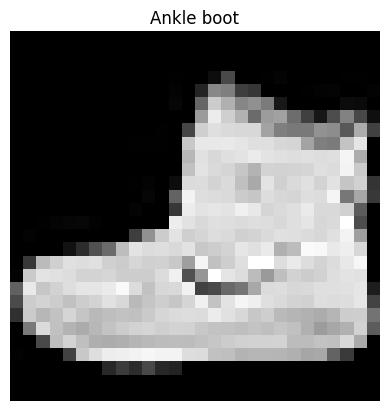

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

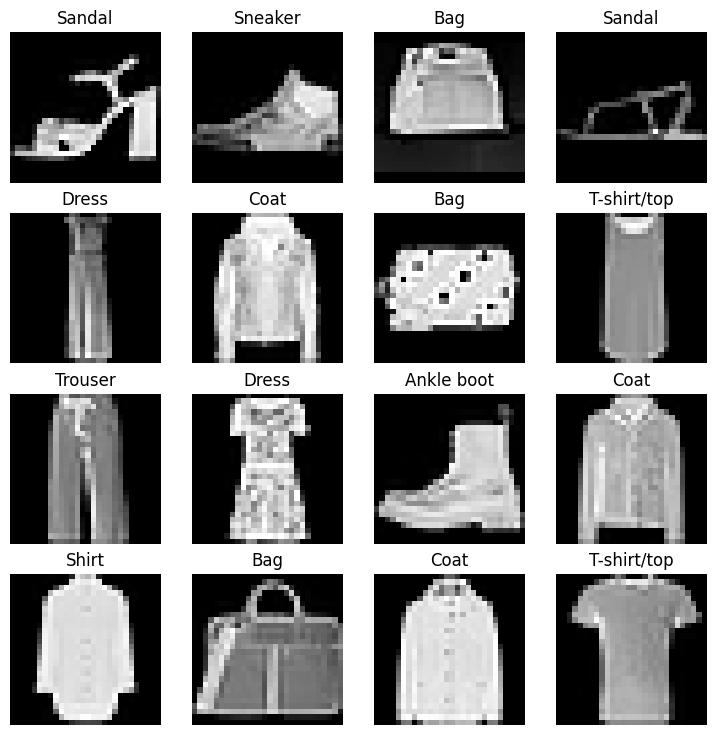

In [ ]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols,i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

# 2. Preparing Dataloader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloaders {train_dataloader, test_dataloader}")
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders (<torch.utils.data.dataloader.DataLoader object at 0x7a0ff302f820>, <torch.utils.data.dataloader.DataLoader object at 0x7a0ff302feb0>)
Train dataloader: 1875 batches of 32
Test dataloader: 313 batches of 32


# 3. Experimenting with differant model

## 3.0 Building traing and testing loop function

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item() # AI suggested this line
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader.dataset)
  print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.2f}")

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      test_acc += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
  test_loss /= len(dataloader)
  test_acc /= len(dataloader.dataset)
  print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}")

In [ ]:
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in train_dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      test_acc += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
  test_loss /= len(train_dataloader)
  test_acc /= len(train_dataloader.dataset)
  return {"model_name": model.__class__.__name__,
          "model_loss": test_loss,
          "model_acc": test_acc}

## 3.1 Baseline model `Simple ANN`

In [ ]:
class SimpleANN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = SimpleANN(input_shape=784, hidden_units=10, output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [ ]:
from tqdm.auto import tqdm
epochs = 10
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_0, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
  test_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.0588 | Train accuracy: 0.62
Test loss: 0.9951 | Test accuracy: 0.64
Epoch: 1
---------
Train loss: 0.9133 | Train accuracy: 0.66
Test loss: 0.9051 | Test accuracy: 0.67
Epoch: 2
---------
Train loss: 0.8798 | Train accuracy: 0.67
Test loss: 0.8948 | Test accuracy: 0.66
Epoch: 3
---------
Train loss: 0.8631 | Train accuracy: 0.68
Test loss: 0.9077 | Test accuracy: 0.66
Epoch: 4
---------
Train loss: 0.8489 | Train accuracy: 0.68
Test loss: 0.8697 | Test accuracy: 0.67
Epoch: 5
---------
Train loss: 0.8396 | Train accuracy: 0.68
Test loss: 0.8851 | Test accuracy: 0.67
Epoch: 6
---------
Train loss: 0.8314 | Train accuracy: 0.69
Test loss: 0.8841 | Test accuracy: 0.67
Epoch: 7
---------
Train loss: 0.8261 | Train accuracy: 0.69
Test loss: 0.8630 | Test accuracy: 0.68
Epoch: 8
---------
Train loss: 0.7878 | Train accuracy: 0.70
Test loss: 0.6837 | Test accuracy: 0.75
Epoch: 9
---------
Train loss: 0.6312 | Train accuracy: 0.77
Test loss: 0.6956 | Test accur

In [ ]:
model_0_results = eval_model(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
model_0_results

{'model_name': 'SimpleANN',
 'model_loss': 0.6269699542959531,
 'model_acc': 0.7676333333333333}

## 3.2 TinyVGG

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=1, hidden_units=10, output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_1, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
  test_step(model=model_1, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.5775 | Train accuracy: 0.79
Test loss: 0.3904 | Test accuracy: 0.86
Epoch: 1
---------
Train loss: 0.3562 | Train accuracy: 0.87
Test loss: 0.3719 | Test accuracy: 0.86
Epoch: 2
---------
Train loss: 0.3182 | Train accuracy: 0.89
Test loss: 0.3303 | Test accuracy: 0.88


In [ ]:
model_1_results = eval_model(model = model_1, dataloader=test_dataloader, loss_fn= loss_fn, device=device)
model_1_results

{'model_name': 'TinyVGG',
 'model_loss': 0.30128502531647683,
 'model_acc': 0.8901}

In [ ]:
torch.save(model_1.state_dict(), "model_1.pth") # saving the model